In [214]:
import os 
import numpy as np 
from scipy.fftpack import fft 
from scipy.io import wavfile

from scipy import signal 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
path_file=os.getcwd()

In [5]:
path_file

'C:\\work\\speech'

In [9]:
os.listdir()

['.ipynb_checkpoints',
 'data_view_processing.ipynb',
 'sample_submission.7z',
 'sample_submission.csv',
 'test',
 'test.7z',
 'train',
 'train.7z']

In [12]:
path_train='C:\\work\\speech\\train\\audio'

In [14]:
categories=os.listdir(path_train)

In [18]:
categories.remove('_background_noise_')

In [266]:
class generate_batch:
    
    def __init__(self,batch_size,path,model):
        self.batch_size=batch_size
        self.path=path
        self.model=model
        self.subdir='audio'
        
        self.path_wave='\\'.join([self.path,self.subdir])
        self.categories=os.listdir(self.path_wave)
        if self.model=='train':
            self.categories.remove('_background_noise_')    # remove noise signal 
        
        self.cate_len={}
        self.cate_index={}
        self.sub_list={}
        for i in self.categories:
            cate_path='\\'.join([self.path_wave,i])
            if i not in self.cate_len.keys():
                self.cate_len[i]=len(os.listdir(cate_path))       # record the len of category list 
                self.cate_index[i]=0                             # initiillize the index of category
                self.sub_list[i]=os.listdir(cate_path)

    def next_patch(self):
        # generate batch 
        label=[]
        generate_x=[]
        for j in self.categories:
            if self.cate_index[j]+batch_size<=self.cate_len[j]:

                list_new=list(range(self.cate_index[j],self.cate_index[j]+batch_size,1))  # generate batch of category i 

                for k in range(batch_size):
                    wave_path='\\'.join([self.path_wave,j,self.sub_list[j][list_new[k]]])     # generate wave path for data input
                    
                    rate,wave=wavfile.read(wave_path)
                    if len(wave)<16000:
                        wave=np.pad(wave,(0,16000-len(wave)),'constant')
                        
                        
                    frequencies, times, spectogram = signal.spectrogram(wave, rate)   # spectogram of wave
                    generate_x.append(spectogram)           # generate the data x  
                    label.append(j)                         # generate the label y  
                    
                self.cate_index[j]=self.cate_index[j]+batch_size
            elif self.cate_index[j]+batch_size>self.cate_len[j]:
                list_new=list(range(self.cate_index[j],self.cate_len[j],1)) \
                        +list(range(0,batch_size+self.cate_index[j]-self.cate_len[j],1))
                for k in range(batch_size):
                    wave_path='\\'.join([self.path_wave,j,self.sub_list[j][list_new[k]]])
                    
                    if len(wave)<16000:
                        wave=np.pad(wave,(0,16000-len(wave)),'constant')
                    frequencies, times, spectogram = signal.spectrogram(wave, rate)   # spectogram of wave
                    
                    generate_x.append(spectogram)
                    label.append(j)                        # generate the label y 
                cate_index[j]=cate_index[j]+batch_size-cate_len[j]
                        
        return generate_x,label
        

        
        


In [267]:
batch_size=1000
epoch=10
path_train='C:\\work\\speech\\train'
dataset=generate_batch(batch_size*epoch,path_train,'train')
train_x,train_y=dataset.next_patch()

Le=LabelEncoder()
Le.fit(train_y)
train_y=Le.transform(train_y)

Oh=OneHotEncoder()
train_y=train_y.reshape(len(train_y),1)
Oh.fit(train_y)
train_y=Oh.transform(train_y)

In [281]:
train_x[1].shape

(129, 71)

In [138]:
from keras.layers import Input,Convolution2D,MaxPooling2D,Dense,BatchNormalization,Flatten,Dropout
from keras.models import Model
from keras import activations,optimizers,activations,losses

In [300]:
try:
    del model
except:
    pass

drop_rate=0.3
input_shape=[129,71,1]
n_class=30


input_s=Input(shape=input_shape)
nb_input=BatchNormalization()(input_s)

# first convolution layer
convo1=Convolution2D(16,kernel_size=[2,2],strides=(1,1),padding='same',activation=activations.tanh,
                     data_format='channels_last')(nb_input)
max_pool_1=MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(convo1)
drop_1=Dropout(drop_rate)(max_pool_1)

# second convolution layer 
convo2=Convolution2D(16,kernel_size=[2,2],strides=(1,1),padding='same',activation=activations.tanh)(drop_1)
max_pool_2=MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(convo2)
drop_2=Dropout(drop_rate)(max_pool_2)

# a fully connected layer 
flat=Flatten()(drop_2)

dense1=Dense(64,activation=activations.relu)(flat)
dense2=Dense(32,activation=activations.relu)(dense1)

# output
output=Dense(n_class,activation=activations.softmax)(dense2)



#

model=Model(input_s,output)

opti_Model=optimizers.Adam()

loss_model=losses.categorical_crossentropy

model.compile(optimizer=opti_Model,loss=loss_model)

In [301]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 129, 71, 1)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 129, 71, 1)        4         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 129, 71, 16)       80        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 129, 71, 16)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 129, 71, 16)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 129, 71, 16)       1040      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 129, 71, 16)       0         
__________

In [304]:
batch_size=1000
epoch=10
path_train='C:\\work\\speech\\train'
dataset=generate_batch(batch_size*epoch,path_train,'train')
train_x,train_y=dataset.next_patch()

Le=LabelEncoder()
Le.fit(train_y)
train_y=Le.transform(train_y)

Oh=OneHotEncoder()
train_y=train_y.reshape(len(train_y),1)
Oh.fit(train_y)
train_y=Oh.transform(train_y)

train_x=np.array(train_x).reshape(30000, 129, 71,1)

In [ ]:
model.fit(train_x,train_y.todense(),batch_size=100,epochs=1)

Epoch 1/1
14300/30000 [=============>................] - ETA: 335s - loss: 3.1587

In [306]:
train_x.shape

(30000, 129, 71, 1)

In [307]:
train_y.shape

(30000, 30)

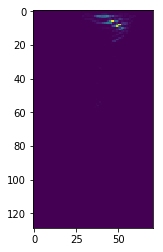

In [126]:
frequencies, times, spectogram = signal.spectrogram(wave, rate)

plt.imshow(spectogram)

In [261]:
c=(np.array(f))


Le=LabelEncoder()
a=Le.fit_transform(c).reshape(60,1)

Oh=OneHotEncoder()
d=Oh.fit_transform((a))

In [262]:
a.shape

(60, 1)

In [263]:
d.shape

(60, 30)

In [211]:
np.array(train_x).shape

(30000, 129, 71)

In [296]:
train_x[1].shape

(129, 71)

In [252]:
f=train_y+train_y

In [297]:
type(train_x)

list

In [310]:
train_y.todense()

matrix([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [54]:
frequencies, times, spectogram = signal.spectrogram(wave, rate)

plt.imshow(spectogram)

In [57]:
spectogram.shape

(129, 71)

In [106]:
def fft_wav(rate,wave):
    windows=0.025*rate
    spectoram=[]
    i=0
    while (i+1)*windows<len(wave):
        print(i*windows)
        fft_win=fft(wave[int(i*windows):int((i+1)*windows)])
        spectoram.append(list(map(lambda x:x.real,fft_win*np.conj(fft_win))))
    
        
        i+=1
    return spectoram

In [107]:
d=fft_wav(rate,wave)

0.0
400.0
800.0
1200.0
1600.0
2000.0
2400.0
2800.0
3200.0
3600.0
4000.0
4400.0
4800.0
5200.0
5600.0
6000.0
6400.0
6800.0
7200.0
7600.0
8000.0
8400.0
8800.0
9200.0
9600.0
10000.0
10400.0
10800.0
11200.0
11600.0
12000.0
12400.0
12800.0
13200.0
13600.0
14000.0
14400.0
14800.0
15200.0


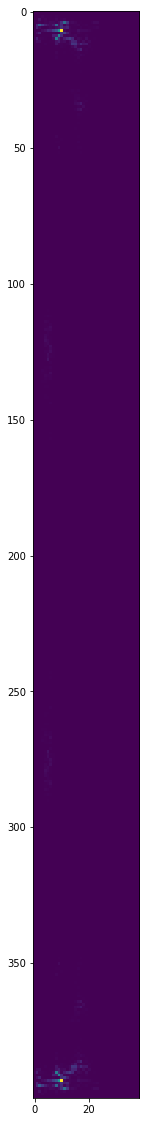

In [110]:
plt.figure(figsize=(5,20))
plt.imshow(np.transpose(d))

In [80]:
c=complex(1+2j)

In [91]:
a=complex(2+3j)

In [92]:
e=[c,a]

In [95]:
e*np.conj(e).real

array([ 1.+2.j,  4.+6.j])

In [96]:
c.real

1.0

In [98]:
d.real

AttributeError: 'list' object has no attribute 'real'

In [102]:
d

[(<function __main__.fft_wav.<locals>.<lambda>>,
  array([  1.79828100e+06+0.j,   8.41681896e+06+0.j,   2.46344289e+07+0.j,
           1.76914636e+08+0.j,   8.93376981e+08+0.j,   5.54758103e+07+0.j,
           7.23358212e+08+0.j,   1.24222174e+09+0.j,   2.70716107e+08+0.j,
           1.54895993e+08+0.j,   2.79290743e+09+0.j,   5.05286848e+08+0.j,
           4.98542064e+08+0.j,   3.75869647e+08+0.j,   2.12756593e+08+0.j,
           1.11118220e+08+0.j,   7.88609059e+07+0.j,   1.97842528e+07+0.j,
           3.57652112e+06+0.j,   7.20658747e+06+0.j,   8.81883969e+06+0.j,
           1.19040738e+07+0.j,   1.24691658e+07+0.j,   1.23448349e+07+0.j,
           1.00078759e+07+0.j,   6.89409309e+06+0.j,   4.45297124e+06+0.j,
           5.94473286e+06+0.j,   2.57025748e+06+0.j,   5.94782277e+06+0.j,
           1.06175280e+07+0.j,   1.63707050e+07+0.j,   2.72595791e+07+0.j,
           3.86080766e+07+0.j,   3.37758045e+07+0.j,   3.31937300e+07+0.j,
           1.84615897e+07+0.j,   8.59601439e+06+0.j